In [1]:
using Images, ImageFeatures, FileIO, ImageView, ImageDraw, Colors

img1 = load("../test/imgs/1.jpg");
img2 = load("../test/imgs/2.jpg");

In [2]:
img1p = parent(img1);
img2p = parent(img2);

In [3]:
function get_descriptors(img::AbstractArray)
    imgp = parent(img)
    brisk_params = ImageFeatures.BRISK()
    features = ImageFeatures.Features(Keypoints(imcorner(imgp, method=ImageFeatures.harris)))
    desc, ret_features = ImageFeatures.create_descriptor(Gray.(imgp), features, brisk_params)
end


get_descriptors (generic function with 1 method)

In [4]:
desc_1, ret_features_1 = get_descriptors(img1p);
desc_2, ret_features_2 = get_descriptors(img2p);

In [5]:
threshold = 0.1;
matches = ImageFeatures.match_keypoints(Keypoints(ret_features_1), Keypoints(ret_features_2), desc_1, desc_2, threshold);

In [6]:
typeof(matches)
axes(matches)

(Base.OneTo(5631),)

In [7]:
function pad_display(img1, img2)
    img1h = length(axes(img1, 1))
    img2h = length(axes(img2, 1))
    mx = max(img1h, img2h);
    hcat(vcat(img1, zeros(RGB{Float64}, max(0, mx - img1h), length(axes(img1, 2)))),
        vcat(img2, zeros(RGB{Float64}, max(0, mx - img2h), length(axes(img2, 2)))))
end


pad_display (generic function with 1 method)

In [8]:
function draw_matches(img1, img2, matches)
    # instead of having grid = [img1 img2], we'll use the new
    # pad_display() function
    grid = pad_display(parent(img1), parent(img2));
    offset = CartesianIndex(0, size(img1, 2));
    println(offset, length(axes(img1, 2)))
    for m in matches[1:100]
        ImageDraw.draw!(grid, LineSegment(m[1], m[2] + offset))  # , colorant"yellow" , colormap(N=100)
    end
    grid
end


draw_matches (generic function with 1 method)

CartesianIndex(0, 1280)1280


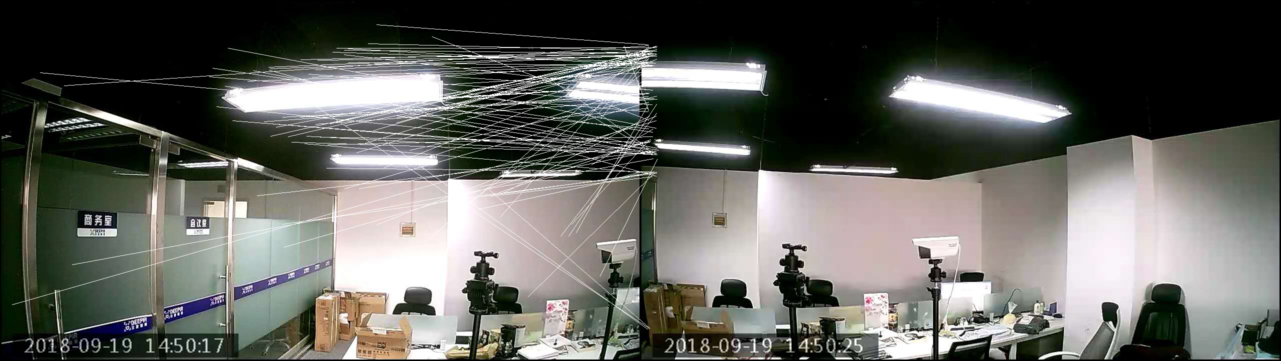

In [9]:
draw_matches(img1, img2, matches)

In [11]:
using CoordinateTransformations, StaticArrays, ImageTransformations, LinearAlgebra;

In [12]:
struct Homography{T} <: AbstractAffineMap
    m::SMatrix{3, 3, T, 9}
end

# having T in the RHS forces calling the constructor again
Homography(m::AbstractMatrix{}) = Homography(m);

In [47]:
function (trans::Homography{M}){M}(x::SVector{3})
    out = trans.m * x;
    out = out / out[end];
    SVector{2}(out[1:2])
end

function (trans::Homography{M}){M}(x::SVector{2})
    trans(SVector{3}([x[1], x[2], 1.0]))
end

function (trans::Homography{M}){M}(x::CartesianIndex{2})
    trans(SVector{3}([collect(x.I); 1]))
end

function (trans::Homography{M}){M}(x::Tuple{Int, Int})
    trans(CartesianIndex{2}(x))
end

function (trans::Homography{M}){M}(x::Array{CartesianIndex{2}, 1})
    CartesianIndex{2}.([tuple(y...) for y in trunc.(Int, collect.(trans.(x)))])
end

# we need to override the inverse function on our homography
function Base.inv(trans::Homography)
    i = inv(trans.m);
    Homography(i ./ i[end])
end

UndefVarError: UndefVarError: M not defined

In [13]:
function compute_homography(matches::Array{Keypoints})
    # eigenvector of A^T A with the smallest eigenvalue construct A matrix
    A = zeros(2 * length(matches), 9)
    for (index, match) in enumerate(matches)
        match1, match2 = match
        base_index_x = index * 2 - 1
        base_index_y = 1:3
        A[base_index_x, base_index_y] = float([match1.I...; 1;])
        A[base_index_x + 1, 4:6] = A[base_index_x, base_index_y]
        A[base_index_x, 7:9] = -1.0 * A[base_index_x, base_index_y] * match2.I[1]
        A[base_index_x + 1, 7:9] = -1.0 * A[base_index_x, base_index_y] * match2.I[2]
    end
  
    # find the smallest eigenvector, normalize, and reshape
    U, S, Vt = LinearAlgebra.svd(A)  # LinearAlgebra.
    
    # normalize the homography at the end, since we know the (3, 3) entry should be 1.
    H = Homography{Float64}(reshape(Vt[:, end] ./ Vt[end][end], (3, 3))')
end

compute_homography (generic function with 1 method)

In [14]:
H_computed_rot = compute_homography(matches)

Homography{Float64}([-0.475252 -0.344355 437.296; -0.748927 -0.564148 699.358; -0.00111251 -0.000770068 1.0])

In [15]:
H = H_computed_rot
img1_warp = ImageTransformations.warp(img1p, H)
# img1_warp = ImageTransformations.AffineMap(img1, H);

ErrorException: Inverse transformation for Homography{Float64} has not been defined.